Notes:
- Recognize rocks: need to know its color range for thresholding.
- World transformation. *
- Clip after trans. *
- Mapping on world map. *

## Importing libraries

In [172]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
from typing import Tuple
from IPython.display import clear_output
from time import sleep
# Import everything needed to edit/save/watch video clips
import moviepy.editor as mpy
#imageio.plugins.ffmpeg.download()

## Configuration

In [173]:
DEBUG = True
RANDOM_SEED = 3

## Quick Look at the Data
Read in and display a random image from the `training_data` folder

Image dimensions: (160, 320, 3)


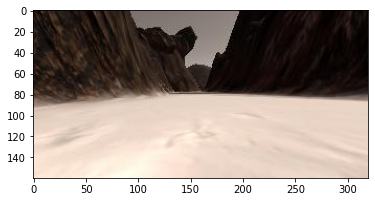

In [174]:
path = './training_data/IMG/*'
img_list = glob.glob(path)

# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])

CAM_IMAGE_SIZE = image.shape[0:2]

if DEBUG:
    print(f'Image dimensions: {image.shape}')

_ = plt.imshow(image)

## Calibration
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

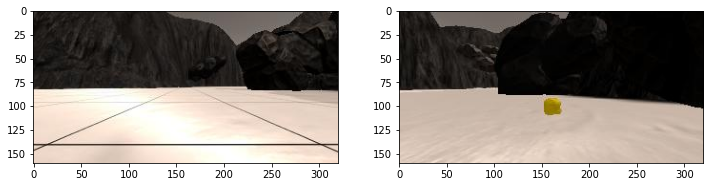

In [175]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = "./calibration_images/example_grid1.jpg"
example_rock = "./calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
_ = plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function

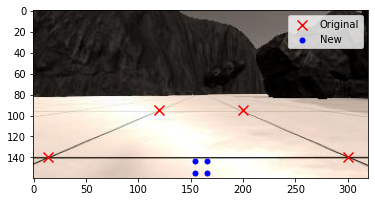

In [176]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return warped

dst = 6
SCALE = dst * 2
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])

if DEBUG:
    plt.imshow(grid_img)
    plt.scatter(source[:, 0], source[:, 1], marker="x", color="red", s=100, label='Original')
    plt.scatter(destination[:, 0], destination[:, 1], marker=".", color="blue", s=100, label='New')
    plt.legend()

Let's test on this image

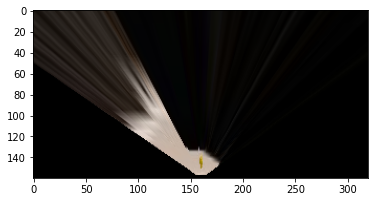

In [177]:
warped = perspect_transform(rock_img, source, destination)
_ = plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

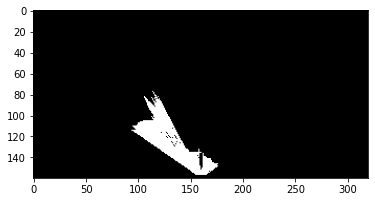

In [178]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] > rgb_thresh[0]) \
                  &(img[:,:, 1] > rgb_thresh[1]) \
                  &(img[:,:, 2] > rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
_ = plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

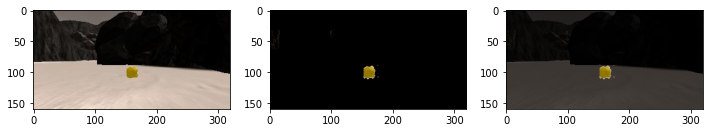

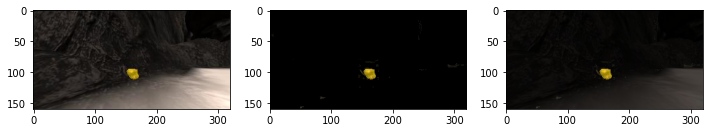

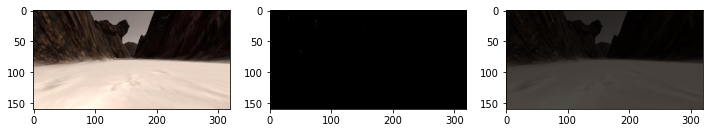

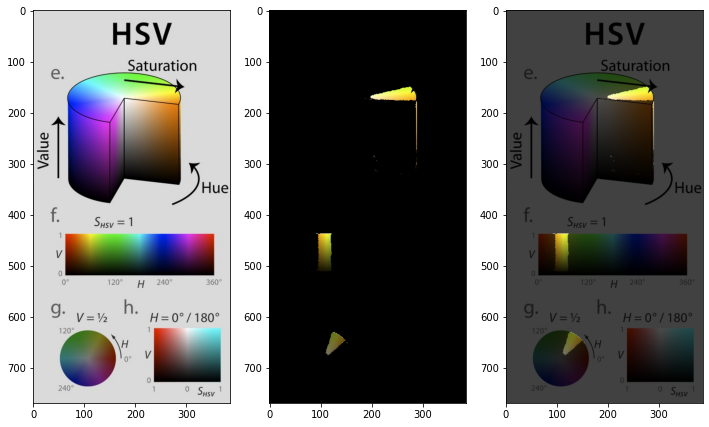

In [179]:
def blend_images(first_img, first_alpha, second_img, second_alpha):
    return cv2.addWeighted(first_img, first_alpha, second_img, second_alpha, 0)

def rock_thresh(image):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, (85, 50, 20), (100, 255, 255))
    imask = mask > 0
    threshed = np.zeros_like(img_hsv, np.uint8)
    threshed[imask] = image[imask]
    blended = blend_images(image, 0.3, threshed, 0.7)
    if DEBUG:
        fig = plt.figure(figsize=(12,9))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(threshed)
        plt.subplot(133)
        plt.imshow(blended)
        
    return threshed, blended
    
_, __ = rock_thresh(rock_img)
_, __ = rock_thresh(mpimg.imread("./calibration_images/example_rock2.jpg"))
_, __ = rock_thresh(image)
_, __ = rock_thresh(mpimg.imread("./calibration_images/hsv.jpg"))

In [180]:
def hsv_thresholding(img, h, s, v):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, (h, s, v), (255, 255, 255))
    imask = mask > 0
    threshed = np.zeros_like(img_hsv, np.uint8)
    threshed[imask] = img[imask]
    blended = cv2.addWeighted(img, 0.3, threshed, 0.7, 0)
    imgs_path = './output/hsv_thresholding_output'
    cv2.imwrite(os.path.join(imgs_path, f'{h}-{s}-{v}.jpg'), blended)
    return blended

def hsv_visualization():
    hsv_cal = mpimg.imread("./calibration_images/hsv.jpg")

    output_path = './output/hsv_thresholds.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'MPEG')
    framerate = 60
    frame_size = (386, 768)
    out = cv2.VideoWriter(output_path, fourcc, framerate, frame_size)
    imgs = []
    
    hsv_img = mpimg.imread("./calibration_images/hsv.jpg")
    
    step_size = 32
    for i in range(0, 257, step_size):
        for j in range(0, 257, step_size):
            for k in range(0, 257, step_size):
                imgs.append(hsv_thresholding(hsv_img, 256 - i, 256 - j, 256 - k))

    imgs = np.array(imgs).astype(np.uint8)
    
    for img in imgs:
        img = cv2.resize(img, frame_size, interpolation = cv2.INTER_AREA)
        out.write(img)
            
hsv_visualization()

# Adjust to world Coordinates

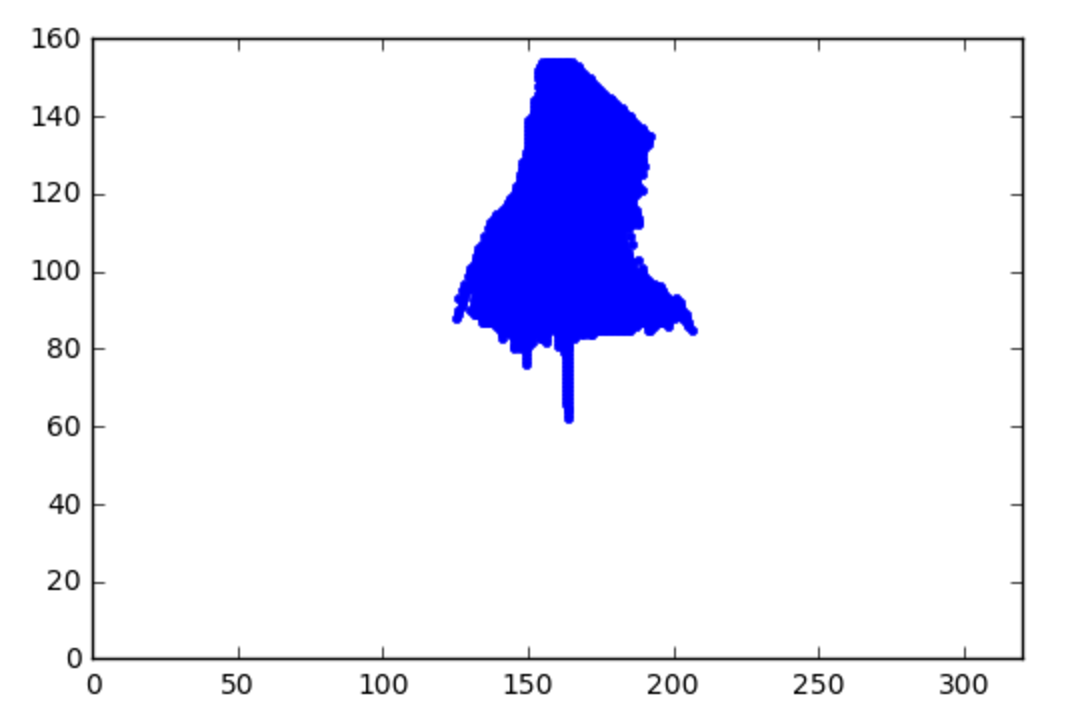

## World Map

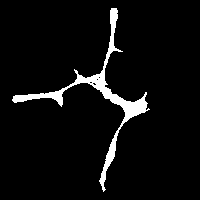

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

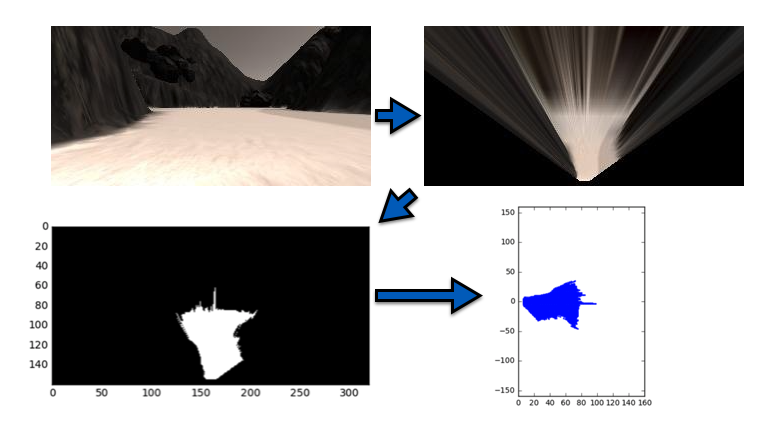

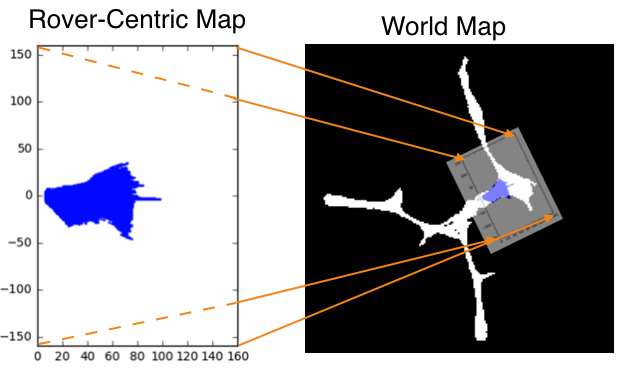

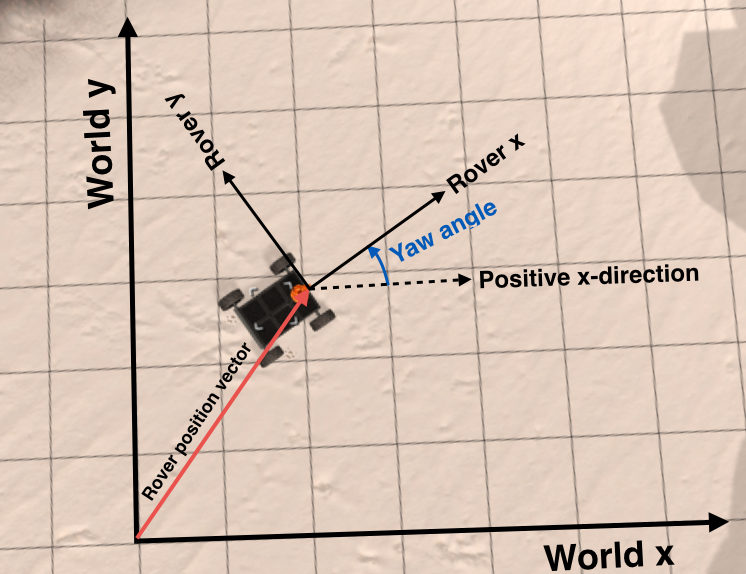

In [181]:
WORLD_SIZE = (200, 200)

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    # Rotate -90 degrees, shift x-axis to center, and reverse y-axis.
    x_pixel = -(ypos - binary_img.shape[1] / 2).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float32)
    
    return x_pixel, y_pixel

# Convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Rotate
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Scale and translate
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, scale, world_size: Tuple[int, int]):
    # Apply rotation
    xpix_rotated, ypix_rotated = rotate_pix(xpix, ypix, yaw)
    xpix_translated, ypix_translated = translate_pix(xpix_rotated, ypix_rotated, xpos, ypos, scale)
    x_pix_world = np.clip(np.int_(xpix_translated), 0, world_size[0] - 1)
    y_pix_world = np.clip(np.int_(ypix_translated), 0, world_size[1] - 1)
    return x_pix_world, y_pix_world

def trans_pix_to_img(xpix: np.ndarray, ypix: np.ndarray, image_dim: Tuple[int, int]) -> np.ndarray:
    img_bw = np.zeros(image_dim)
    img_bw[xpix, ypix] = 1
    return img_bw

#### Let's test these transformations

Load in the `csv` file.

In [182]:
training_data_path = './training_data'
training_data = pd.read_csv(f'{training_data_path}/robot_log.csv', delimiter=',')

In [183]:
training_data.head()

,Path,SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll
0,IMG/robocam_2022_12_05_17_01_11_342.jpg,0.0,0.0,1.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
1,IMG/robocam_2022_12_05_17_01_11_392.jpg,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
2,IMG/robocam_2022_12_05_17_01_11_457.jpg,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
3,IMG/robocam_2022_12_05_17_01_11_523.jpg,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
4,IMG/robocam_2022_12_05_17_01_11_592.jpg,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07


Make the paths relative to the project

In [184]:
training_data['Path'] = f'{training_data_path}/' + training_data['Path'].astype(str)

In [185]:
training_data.head()

,Path,SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll
0,./training_data/IMG/robocam_2022_12_05_17_01_1...,0.0,0.0,1.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
1,./training_data/IMG/robocam_2022_12_05_17_01_1...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
2,./training_data/IMG/robocam_2022_12_05_17_01_1...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
3,./training_data/IMG/robocam_2022_12_05_17_01_1...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07
4,./training_data/IMG/robocam_2022_12_05_17_01_1...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82556,-5.262480e-07


Grab a random reading and test it

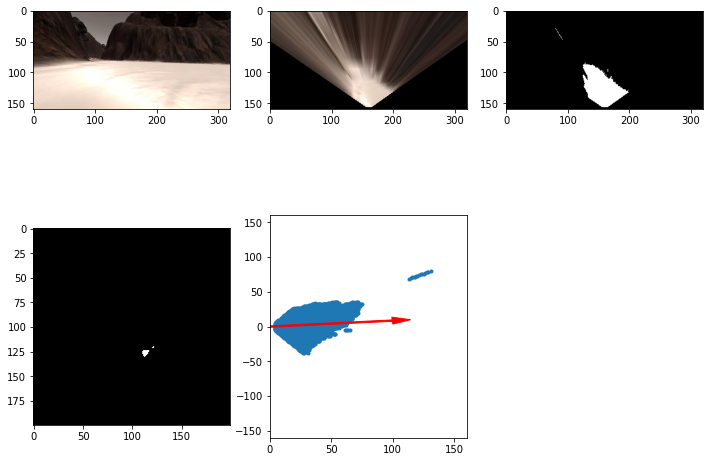

In [186]:
# Grab a random image reading
idx = np.random.randint(0, len(training_data) - 1)
data_point = training_data.iloc[idx]
image = mpimg.imread(data_point['Path'])

warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Transform to world space
xpix_world, ypix_world = pix_to_world(xpix, 
                                      ypix, 
                                      data_point['X_Position'],
                                      data_point['Y_Position'],
                                      data_point['Yaw'],
                                      SCALE,
                                      WORLD_SIZE,)
transformed = trans_pix_to_img(xpix_world, ypix_world, WORLD_SIZE)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(231)
plt.imshow(image)
plt.subplot(232)
plt.imshow(warped)
plt.subplot(233)
plt.imshow(threshed, cmap='gray')
plt.subplot(234)
plt.imshow(transformed, cmap='gray')
plt.subplot(235)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
_ = plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [187]:
def color_transformed_rocks(transformed_rocks):
    rgb_img = cv2.cvtColor(transformed_rocks.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    rgb_img[np.where((rgb_img==[1, 1, 1]).all(axis=2))] = [255, 255, 0]
    return rgb_img

In [81]:
# Add rocks if present
thresholded_rocks, blended_rocks = rock_thresh(image)
color_threshed_rocks = color_thresh(thresholded_rocks)
warped_rocks = perspect_transform(color_threshed_rocks, source, destination)
xpix_rocks, ypix_rocks = rover_coords(color_threshed_rocks)
xpix_world_rocks, ypix_world_rocks = pix_to_world(xpix_rocks, 
                                                  ypix_rocks, 
                                                  data_point['X_Position'],
                                                  data_point['Y_Position'],
                                                  data_point['Yaw'],
                                                  SCALE,
                                                  WORLD_SIZE,)
transformed_rocks = trans_pix_to_img(xpix_world_rocks, ypix_world_rocks, WORLD_SIZE)

colored_transformed_rocks = 

fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped_rocks)
plt.subplot(223)
plt.imshow(thresholded_rocks)
plt.subplot(224)
plt.imshow(transformed_rocks, cmap='gray')

SyntaxError: invalid syntax (2176437152.py, line 15)

In [82]:
yellow_rock_mapping = color_transformed_rocks(transformed_rocks)
transformed_rgb = cv2.cvtColor(transformed.astype(np.uint8), cv2.COLOR_GRAY2RGB) * 255
map_rock_merged = blend_images(transformed_rgb, 1, yellow_rock_mapping, 1)
plt.imshow(map_rock_merged)

NameError: name 'transformed_rocks' is not defined

## Mapping the world from the data

Create a world mapper containg the full process

In [188]:
class WorldMapper:
    def __init__(self, world_size: Tuple[int, int], data_path: str, dst: int = 6):
        self.ground_truth_map: ndarray
        self.map: ndarray = np.zeros(world_size)
        self.world_size: Tuple[int, int] = world_size
        self.data = pd.read_csv(f'{data_path}/robot_log.csv')
        self.data['Path'] = f'{data_path}/' + self.data['Path'].astype(str)
        self.dst = dst
        self.scale = dst * 2
        self.bottom_offset = 5
        self.perspect_source = np.float32([[14, 140],
                                           [300, 140],
                                           [200, 95],
                                           [120, 95]])

        self.perspect_destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                                                [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                                                [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                                                [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])
    
    def reset_map(self):
        self.map = np.zeros(self.world_size)
    
    def steps(self):
        self.reset_map()
        for i in range(len(self.data)):
            data_point = self.data.iloc[i]
            self.map_data_point(data_point)
            yield self.map, i + 1, len(self.data)
    
    def map_data_point(self, data_point) -> None:
        image = mpimg.imread(data_point['Path'])
        transformed = self.transform_image(image, data_point)
        self.map = np.where(transformed != 0, transformed, self.map)
    
    def transform_image(self, image: np.ndarray, data_point) -> np.ndarray:
        # Perspective transformation
        warped = self.perspect_transform(image, source, destination)
        threshed = color_thresh(warped)

        # Calculate pixel values in rover-centric coords and distance/angle to all pixels
        xpix, ypix = rover_coords(threshed)
        dist, angles = to_polar_coords(xpix, ypix)
        mean_dir = np.mean(angles)

        # Transform to world space
        xpix_world, ypix_world = self.pix_to_world(xpix, 
                                                   ypix, 
                                                   data_point['X_Position'],
                                                   data_point['Y_Position'],
                                                   data_point['Yaw'],
                                                   self.scale,
                                                   self.world_size,)
        transformed = self.trans_pix_to_img(xpix_world, ypix_world, self.world_size)
        return transformed
        
    def perspect_transform(self, img, src, dst):
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
        return warped
    
    def rover_coords(self, binary_img):
        # Identify nonzero pixels
        ypos, xpos = binary_img.nonzero()

        # Rotate -90 degrees, shift x-axis to center, and reverse y-axis.
        x_pixel = -(ypos - binary_img.shape[1] / 2).astype(np.float32)
        y_pixel = -(xpos - binary_img.shape[0]).astype(np.float32)

        return x_pixel, y_pixel

    # Convert to radial coords in rover space
    def to_polar_coords(self, x_pixel, y_pixel):
        # Convert (x_pixel, y_pixel) to (distance, angle) 
        # in polar coordinates in rover space
        # Calculate distance to each pixel
        dist = np.sqrt(x_pixel**2 + y_pixel**2)
        angles = np.arctan2(y_pixel, x_pixel)
        return dist, angles

    # Rotate
    def rotate_pix(self, xpix, ypix, yaw):
        yaw_rad = yaw * np.pi / 180
        xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
        ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
        return xpix_rotated, ypix_rotated

    # Scale and translate
    def translate_pix(self, xpix_rot, ypix_rot, xpos, ypos, scale): 
        # Apply a scaling and a translation
        xpix_translated = (xpix_rot / scale) + xpos
        ypix_translated = (ypix_rot / scale) + ypos
        # Return the result 
        return xpix_translated, ypix_translated

    # Define a function to apply rotation and translation (and clipping)
    # Once you define the two functions above this function should work
    def pix_to_world(self, xpix, ypix, xpos, ypos, yaw, scale, world_size: Tuple[int, int]):
        # Apply rotation
        xpix_rotated, ypix_rotated = self.rotate_pix(xpix, ypix, yaw)
        xpix_translated, ypix_translated = self.translate_pix(xpix_rotated, ypix_rotated, xpos, ypos, scale)
        x_pix_world = np.clip(np.int_(xpix_translated), 0, world_size[0] - 1)
        y_pix_world = np.clip(np.int_(ypix_translated), 0, world_size[1] - 1)
        return x_pix_world, y_pix_world

    def trans_pix_to_img(self, xpix: np.ndarray, ypix: np.ndarray, image_dim: Tuple[int, int]) -> np.ndarray:
        img_bw = np.zeros(image_dim)
        img_bw[xpix, ypix] = 1
        return img_bw
    

In [189]:
def trans_map(map):
    return cv2.rotate(map, cv2.ROTATE_90_COUNTERCLOCKWISE)

def show_map(map):
    rot = trans_map(map)
    plt.imshow(rot, cmap='gray', origin='lower')
    plt.show()

Create a world mapper instance

In [190]:
mapper = WorldMapper(WORLD_SIZE, training_data_path)

Create world map & calculate accuracy

In [214]:
def create_map():
    steps = mapper.steps()
    for i in range(len(mapper.data)):
        step, done, total = next(steps)
    return trans_map(step)[::-1, :]

In [224]:
def calc_map_accuracy(nmap, omap):
    bright_percentage = (len(np.where((nmap!=0)&(omap!=0))[0])/(len(np.where(omap!=0)[0])))*100
    dark_percentage = (len(np.where((nmap==0)&(omap==0))[0])/(len(np.where(omap==0)[0])))*100
    percentage = (bright_percentage+dark_percentage)/2
    return print("Accuracy of map: {:.2f}%".format(percentage))

In [216]:
new_map = create_map()

In [217]:
old_map = cv2.cvtColor(cv2.imread('./calibration_images/map_bw.png'), cv2.COLOR_BGR2GRAY)

In [225]:
calc_map_accuracy(new_map, old_map)

Accuracy of map: 97.50%


Create a video for the mapping process from begin to end

In [69]:
steps = mapper.steps()

def make_frame(i: int):
    step, done, total = next(steps)
    step = trans_map(step)[::-1, :]
    step = np.repeat(step[:, :, np.newaxis], repeats=3, axis=2) * 255
    return step

fps = 60
duration = (len(mapper.data) - 1) / fps
    
output = './output/training_mapping.mp4'
clip = mpy.VideoClip(make_frame, duration=duration)
%time clip.write_videofile(output, fps=fps, audio=False)

                                                                                                                                                                                                                   

                                                                                                                                                                                                             
t:   1%|█                                                                                                                                                          | 2/300 [44:32<110:36:29, 1336.21s/it, now=None]

t:   0%|                                                                                                                                                           | 2/4168 [04:48<166:50:04, 144.17s/it, now=None]
                                                                                                                                                            

Moviepy - Building video ./output/training_mapping.mp4.
Moviepy - Writing video ./output/training_mapping.mp4






t:   0%|                                                                                                                                                                        | 0/4168 [00:00<?, ?it/s, now=None]


t:   0%|▌                                                                                                                                                             | 16/4168 [00:00<00:26, 158.03it/s, now=None]


t:   1%|█▏                                                                                                                                                            | 32/4168 [00:00<00:29, 139.29it/s, now=None]


t:   1%|█▊                                                                                                                                                            | 47/4168 [00:00<00:33, 121.66it/s, now=None]


t:   2%|██▍                                                                                                                                  

Moviepy - Done !
Moviepy - video ready ./output/training_mapping.mp4
CPU times: user 23.2 s, sys: 686 ms, total: 23.8 s
Wall time: 25.6 s
